# March Madness Prediction Models
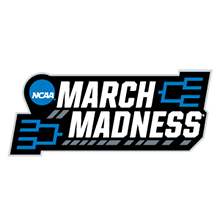 

In [168]:
import seaborn as sns
import numpy as np 
import pandas as pd 
import os
import random
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 
#import xgboost as xgb
from sklearn import svm
from sklearn import grid_search

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Import four Data sets from Kaggle's competition Site 
(https://www.kaggle.com/c/march-machine-learning-mania-2017):<br>
1. Tourney<br>
2. Seeds<br>
3. Rank<br>
4. RegularSeason<br>

In [2]:
Tourney = pd.read_csv('C:/Users/NAVEP/Documents/NaveDS/NCAATourneyCompactResults.csv')
Tourney.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
2179,2018,146,1242,85,1181,81,N,1
2180,2018,146,1437,71,1403,59,N,0
2181,2018,152,1276,69,1260,57,N,0
2182,2018,152,1437,95,1242,79,N,0
2183,2018,154,1437,79,1276,62,N,0


In [3]:
Seeds = pd.read_csv('C:/Users/NAVEP/Documents/NaveDS/2019/Stage2DataFiles/NCAATourneySeeds.csv')
Seeds.tail()

,Season,Seed,TeamID
2281,2019,Z12,1332
2282,2019,Z13,1414
2283,2019,Z14,1330
2284,2019,Z15,1159
2285,2019,Z16,1205


In [4]:
Rank = pd.read_csv('C:/Users/NAVEP/Documents/NaveDS/2019/MasseyOrdinals_thru_2019_day_128/MasseyOrdinals_thru_2019_day_128.csv')
Rank.tail()



,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
3798251,2019,128,ZAM,1462,76
3798252,2019,128,ZAM,1463,91
3798253,2019,128,ZAM,1464,245
3798254,2019,128,ZAM,1465,202
3798255,2019,128,ZAM,1466,287


In [5]:
RegularSeason = pd.read_csv('C:/Users/NAVEP/Documents/NaveDS/2019/Prelim2019_RegularSeasonDetailedResults.csv')
pd.options.display.max_columns = None
RegularSeason.tail()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
87361,2019,128,1412,70,1292,61,N,0,24,49,5,14,17,24,8,24,8,11,7,2,11,24,58,10,30,3,6,10,20,13,14,5,3,20
87362,2019,128,1417,79,1390,72,N,0,25,61,7,16,22,35,12,37,9,15,7,1,20,27,76,7,25,11,20,18,30,11,12,7,9,22
87363,2019,128,1425,78,1112,65,N,0,29,60,8,22,12,19,6,24,10,8,6,5,19,23,57,5,22,14,19,11,28,11,12,3,6,17
87364,2019,128,1439,71,1274,56,N,0,27,54,11,27,6,7,8,28,17,10,4,3,15,19,56,8,29,10,14,10,20,10,8,3,0,10
87365,2019,128,1452,72,1328,71,N,0,27,71,9,30,9,13,16,30,12,9,5,6,16,28,62,4,12,11,13,5,31,12,8,6,1,15


# 1. Data Wrangling

First, we’ll generate the data so it will be in a proportional order to Our Prediction in the ‘Result’ column.
This way all the factors will influence on the models predictions in the same direction.
Result = 0:Team1 lost ; 1:Team1 Won

In [6]:
Tourney = Tourney.loc[Tourney['Season'] >= 2003]
training_set = pd.DataFrame()

# generate the same number sequence every time - 'Result' Coulmn
np.random.seed(9001)

training_set['Result'] = np.random.randint(0,2,len(Tourney.index))
training_set['Season'] = Tourney['Season'].values
training_set['Team1'] = training_set['Result'].values * Tourney['WTeamID'].values + (1-training_set['Result'].values) * Tourney['LTeamID'].values 
training_set['Team2'] = (1-training_set['Result'].values) * Tourney['WTeamID'].values + training_set['Result'].values * Tourney['LTeamID'].values

training_set.tail()

,Result,Season,Team1,Team2
1043,1,2018,1242,1181
1044,0,2018,1403,1437
1045,0,2018,1260,1276
1046,1,2018,1437,1242
1047,0,2018,1276,1437


DeltaSeed : difference in team's seeds (Seed of team 1 in the beginning of the tournament - Seed of team 2 in the beginning of the tournament)

In [7]:
Seeds['Seed'] =  pd.to_numeric(Seeds['Seed'].str[1:3], downcast='integer',errors='coerce')

def delta_seed(row):
    cond = (Seeds['Season'] == row['Season'])
    return Seeds[cond & (Seeds['TeamID'] == row['Team1'])]['Seed'].iloc[0] - Seeds[cond & (Seeds['TeamID'] == row['Team2'])]['Seed'].iloc[0]

training_set['deltaSeed'] = training_set.apply(delta_seed,axis=1)

training_set.tail()

,Result,Season,Team1,Team2,deltaSeed
1043,1,2018,1242,1181,-1
1044,0,2018,1403,1437,2
1045,0,2018,1260,1276,8
1046,1,2018,1437,1242,0
1047,0,2018,1276,1437,2


DeltaRank : Team1 ranking - Team2 ranking. Difference in team's Massey Ordinals on day 128. The numbers are decimal, because each ranking is a mean of few Ranking sources.

In [8]:
Rank = Rank[(Rank['RankingDayNum'] == 128) & (Rank['Season'] >= 2003)] # See Note on MO

def delta_ord(row):
    cond =  (Rank['Season'] == row['Season'])
    cond1 = (Rank['TeamID'] == row['Team1']) & cond
    cond2 = (Rank['TeamID'] == row['Team2']) & cond
    t1 = Rank[cond1]['OrdinalRank'].mean()
    t2 = Rank[cond2]['OrdinalRank'].mean()
    return  t1-t2

training_set['deltaRank'] = training_set.apply(delta_ord,axis=1)

training_set.tail()

,Result,Season,Team1,Team2,deltaSeed,deltaRank
1043,1,2018,1242,1181,-1,5.030303
1044,0,2018,1403,1437,2,12.166667
1045,0,2018,1260,1276,8,34.407648
1046,1,2018,1437,1242,0,-6.742424
1047,0,2018,1276,1437,2,8.954545


DeltaWinPct: Team1 WinPct - Team2 WinPct.  difference in the team's winning percentage

In [9]:
record = pd.DataFrame({'wins': RegularSeason.groupby(['Season','WTeamID']).size()}).reset_index();
losses = pd.DataFrame({'losses': RegularSeason.groupby(['Season','LTeamID']).size()}).reset_index();

record = record.merge(losses, how='outer', left_on=['Season','WTeamID'], right_on=['Season','LTeamID'])
record = record.fillna(0)
record['games'] = record['wins'] + record['losses']

def delta_winPct(row):
    cond1 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team1'])
    cond2 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team2'])
    return (record[cond1]['wins']/record[cond1]['games']).mean() - (record[cond2]['wins']/record[cond2]['games']).mean()

training_set['deltaWinPct'] = training_set.apply(delta_winPct,axis=1)

training_set.tail()

,Result,Season,Team1,Team2,deltaSeed,deltaRank,deltaWinPct
1043,1,2018,1242,1181,-1,5.030303,0.006239
1044,0,2018,1403,1437,2,12.166667,-0.155080
1045,0,2018,1260,1276,8,34.407648,0.049632
1046,1,2018,1437,1242,0,-6.742424,0.088235
1047,0,2018,1276,1437,2,8.954545,-0.088235


Points for and points against for each team. this value will be calculated as a delta for each game, with all the rest of the stats from the regular season.

In [10]:
dfW = RegularSeason.groupby(['Season','WTeamID']).sum().reset_index()
dfL = RegularSeason.groupby(['Season','LTeamID']).sum().reset_index()

def get_points_for(row):
    wcond = (dfW['Season'] == row['Season']) & (dfW['WTeamID'] == row['WTeamID']) 
    fld1 = 'WScore'
    lcond = (dfL['Season'] == row['Season']) & (dfL['LTeamID'] == row['WTeamID']) 
    fld2 = 'LScore'
    retVal = dfW[wcond][fld1].sum()
    if len(dfL[lcond][fld2]) > 0:
        retVal = retVal + dfL[lcond][fld2].sum() 
    return retVal

def get_points_against(row):
    wcond = (dfW['Season'] == row['Season']) & (dfW['WTeamID'] == row['WTeamID']) 
    fld1 = 'LScore'
    lcond = (dfL['Season'] == row['Season']) & (dfL['LTeamID'] == row['WTeamID']) 
    fld2 = 'WScore'
    retVal = dfW[wcond][fld1].sum()
    if len(dfL[lcond][fld2]) > 0:
        retVal = retVal + dfL[lcond][fld2].sum() 
    return retVal

record['PointsFor'] = record.apply(get_points_for,axis=1)
record['PointsAgainst'] = record.apply(get_points_against,axis=1)

record.tail(10)

,Season,WTeamID,wins,LTeamID,losses,games,PointsFor,PointsAgainst
5824,2019,1462.0,17.0,1462.0,14.0,31.0,2242,2198
5825,2019,1463.0,19.0,1463.0,7.0,26.0,2085,1902
5826,2019,1464.0,10.0,1464.0,20.0,30.0,2205,2377
5827,2019,1465.0,12.0,1465.0,14.0,26.0,1962,1955
5828,2019,1466.0,7.0,1466.0,22.0,29.0,1903,2173
5829,2005,0.0,0.0,1366.0,28.0,28.0,0,0
5830,2008,0.0,0.0,1312.0,29.0,29.0,0,0
5831,2013,0.0,0.0,1212.0,28.0,28.0,0,0
5832,2015,0.0,0.0,1212.0,27.0,27.0,0,0
5833,2015,0.0,0.0,1363.0,28.0,28.0,0,0


Now, we'll calculate the cumulative stats for each team in specific regular season. in the next line, we'll generate it to a Delta for every game.  

In [11]:
def get_remaining_stats(row, field):
    wcond = (dfW['Season'] == row['Season']) & (dfW['WTeamID'] == row['WTeamID']) 
    fld1 = 'W' + field
    lcond = (dfL['Season'] == row['Season']) & (dfL['LTeamID'] == row['WTeamID']) 
    fld2 = 'L'+ field
    retVal = dfW[wcond][fld1].sum()
    if len(dfL[lcond][fld2]) > 0:
        retVal = retVal + dfL[lcond][fld2].sum()
    return retVal

cols1 = ['FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']

for col in cols1:
    record[col] = record.apply(get_remaining_stats, args=(col,), axis=1)
    
record.tail()

,Season,WTeamID,wins,LTeamID,losses,games,PointsFor,PointsAgainst,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
5829,2005,0.0,0.0,1366.0,28.0,28.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5830,2008,0.0,0.0,1312.0,29.0,29.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5831,2013,0.0,0.0,1212.0,28.0,28.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5832,2015,0.0,0.0,1212.0,27.0,27.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5833,2015,0.0,0.0,1363.0,28.0,28.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
def delta_stat(row, field):
    cond1 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team1'])
    cond2 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team2'])
    return (record[cond1][field]/record[cond1]['games']).mean() - (record[cond2][field]/record[cond2]['games']).mean()

cols = ['PointsFor','PointsAgainst','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']

for col in cols:
    training_set['delta' + col] = training_set.apply(delta_stat,args=(col,),axis=1)

training_set.describe()

,Result,Season,Team1,Team2,deltaSeed,deltaRank,deltaWinPct,deltaPointsFor,deltaPointsAgainst,deltaFGM,deltaFGA,deltaFGM3,deltaFGA3,deltaFTM,deltaFTA,deltaOR,deltaDR,deltaAst,deltaTO,deltaStl,deltaBlk,deltaPF
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000
mean,0.520992,2010.591603,1295.011450,1295.112595,-0.149809,-1.029887,0.005362,0.098984,-0.141496,0.022190,-0.019946,-0.016426,-0.047430,0.071030,0.029915,-0.039822,-0.065081,-0.019438,-0.088584,0.018409,-0.060647,0.082645
std,0.499798,4.611062,105.378156,103.377854,7.470763,67.660351,0.143601,7.282355,6.427739,2.900496,4.896147,1.788489,4.162790,2.733694,3.682619,2.565679,2.496315,2.564548,2.083252,1.842908,1.877742,2.558787
min,0.000000,2003.000000,1103.000000,1102.000000,-15.000000,-289.861905,-0.633333,-21.643382,-19.145650,-8.602941,-17.404412,-6.062500,-14.278495,-8.059629,-10.772059,-7.924632,-9.010776,-6.562500,-7.666667,-6.283681,-6.360606,-7.256303
25%,0.000000,2007.000000,1211.000000,1211.000000,-5.000000,-27.283758,-0.088235,-4.615152,-4.605835,-1.971928,-3.437973,-1.211245,-2.791835,-1.726461,-2.392472,-1.803267,-1.741090,-1.786735,-1.409759,-1.208884,-1.245005,-1.813698
50%,1.000000,2011.000000,1285.000000,1287.000000,0.000000,0.038406,0.000000,-0.055899,0.008761,0.006763,0.028883,-0.022031,-0.029684,0.213430,0.004724,-0.125678,-0.079597,-0.097687,-0.103704,-0.013169,0.022885,0.210080
75%,1.000000,2015.000000,1393.000000,1393.000000,5.000000,24.854060,0.094655,4.964615,4.141195,2.033442,3.086465,1.172600,2.645561,2.038220,2.379412,1.636364,1.558824,1.704372,1.268328,1.250334,1.126941,1.808263
max,1.000000,2018.000000,1462.000000,1463.000000,15.000000,278.426564,0.515152,22.892857,25.035714,9.357143,22.071429,5.246324,12.439377,7.731034,10.827586,9.214286,9.285714,9.220143,7.580645,6.090133,6.752688,7.896552


In [13]:
training_set.head()

,Result,Season,Team1,Team2,deltaSeed,deltaRank,deltaWinPct,deltaPointsFor,deltaPointsAgainst,deltaFGM,deltaFGA,deltaFGM3,deltaFGA3,deltaFTM,deltaFTA,deltaOR,deltaDR,deltaAst,deltaTO,deltaStl,deltaBlk,deltaPF
0,1,2003,1421,1411,0,19.000000,-0.151724,-1.593103,7.614943,-0.354023,1.526437,0.549425,-0.500000,-1.434483,-7.135632,-0.890805,-1.627586,-1.165517,0.973563,0.635632,0.766667,0.803448
1,0,2003,1436,1112,15,132.000000,-0.237685,-17.421182,-7.112069,-5.493842,-9.852217,-1.759852,-4.588670,-4.673645,-5.448276,-2.213054,-1.918719,-3.435961,-0.716749,-1.602217,-1.248768,-1.853448
2,1,2003,1113,1272,3,12.333333,-0.172414,1.448276,3.344828,0.931034,-3.103448,-3.000000,-7.482759,2.586207,3.310345,-0.379310,-2.655172,-1.068966,0.206897,-2.172414,-0.827586,0.655172
3,0,2003,1166,1141,-5,-40.333333,0.085684,-0.102403,-8.908046,2.076280,4.764890,1.142111,2.553814,-5.397074,-5.142111,0.292581,-0.094044,1.197492,-4.877743,1.290491,0.454545,-3.692790
4,1,2003,1143,1301,-1,-35.333333,0.124138,2.082759,1.758621,3.011494,5.390805,-1.552874,-5.465517,-2.387356,-0.949425,1.508046,2.345977,1.333333,-0.027586,-1.214943,-0.273563,-1.563218


In [14]:
cols2=['deltaSeed','deltaRank','deltaWinPct','deltaPointsFor','deltaPointsAgainst','deltaFGM','deltaFGA','deltaFGM3','deltaFGA3','deltaFTM','deltaFTA','deltaOR','deltaDR','deltaAst','deltaTO','deltaStl','deltaBlk','deltaPF']
X = training_set[cols2]
y = training_set['Result']

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())   




         Current function value: 0.529647
         Iterations: 35
                                 Results: Logit
Model:                    Logit                 Pseudo R-squared:      0.235     
Dependent Variable:       Result                AIC:                   1144.1405 
Date:                     2019-03-24 22:45      BIC:                   1228.3694 
No. Observations:         1048                  Log-Likelihood:        -555.07   
Df Model:                 16                    LL-Null:               -725.49   
Df Residuals:             1031                  LLR p-value:           8.3593e-63
Converged:                0.0000                Scale:                 1.0000    
No. Iterations:           35.0000                                                
---------------------------------------------------------------------------------
                    Coef.    Std.Err.      z    P>|z|      [0.025       0.975]   
------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Building the Sub file: to build the data set that the chosen model will use to predict the 2019 contest!

In [183]:
SS2 = pd.read_csv('C:/Users/NAVEP/Documents/NaveDS/2019/SampleSubmissionStage2.csv')
SS2.tail()

,ID,Pred
2273,2019_1449_1459,0.5
2274,2019_1449_1463,0.5
2275,2019_1458_1459,0.5
2276,2019_1458_1463,0.5
2277,2019_1459_1463,0.5


In [184]:
sub = pd.DataFrame()
sub['Season'] =SS2['ID'].map(lambda x: x.split('_')[0]).astype(int)
sub['Team1'] = SS2['ID'].map(lambda x: x.split('_')[1]).astype(int)
sub['Team2'] = SS2['ID'].map(lambda x: x.split('_')[2]).astype(int)
 
sub.dtypes

Season    int32
Team1     int32
Team2     int32
dtype: object

In [185]:
sub['deltaSeed'] = X_test.apply(delta_seed,axis=1)

sub.tail()

,Season,Team1,Team2,deltaSeed
2273,2019,1449,1459,NaN
2274,2019,1449,1463,NaN
2275,2019,1458,1459,NaN
2276,2019,1458,1463,NaN
2277,2019,1459,1463,NaN


In [186]:
sub['deltaRank'] = X_test.apply(delta_ord,axis=1)

sub.tail()

,Season,Team1,Team2,deltaSeed,deltaRank
2273,2019,1449,1459,NaN,NaN
2274,2019,1449,1463,NaN,NaN
2275,2019,1458,1459,NaN,NaN
2276,2019,1458,1463,NaN,NaN
2277,2019,1459,1463,NaN,NaN


In [187]:
sub['deltaWinPct'] = sub.apply(delta_winPct,axis=1)
sub.tail()

,Season,Team1,Team2,deltaSeed,deltaRank,deltaWinPct
2273,2019,1449,1459,NaN,NaN,-0.092473
2274,2019,1449,1463,NaN,NaN,0.043424
2275,2019,1458,1459,NaN,NaN,-0.156989
2276,2019,1458,1463,NaN,NaN,-0.021092
2277,2019,1459,1463,NaN,NaN,0.135897


In [188]:
cols_3 = ['PointsFor','PointsAgainst','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']

for col in cols_3:
    sub['delta' + col] = X_test.apply(delta_stat,args=(col,),axis=1)

sub.describe()

,Season,Team1,Team2,deltaSeed,deltaRank,deltaWinPct,deltaPointsFor,deltaPointsAgainst,deltaFGM,deltaFGA,deltaFGM3,deltaFGA3,deltaFTM,deltaFTA,deltaOR,deltaDR,deltaAst,deltaTO,deltaStl,deltaBlk,deltaPF
count,2278.0,2278.000000,2278.000000,104.000000,104.000000,2278.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,2019.0,1236.069798,1352.606673,-0.846154,-7.209644,-0.012605,0.550377,-0.187952,0.272066,0.165437,-0.124171,-0.384626,0.130417,0.273067,0.052058,0.045615,0.041019,-0.317264,0.069762,0.052870,-0.159651
std,0.0,82.692179,80.234060,7.217521,65.069205,0.156225,7.449202,6.679751,2.819829,4.870954,1.765007,4.068157,2.996158,4.132798,2.531263,2.243863,2.472047,2.151792,1.876207,1.866877,2.652034
min,2019.0,1101.000000,1113.000000,-15.000000,-224.428033,-0.488889,-18.452206,-15.163102,-7.058824,-9.471591,-4.450304,-9.033333,-7.562500,-10.062500,-5.096970,-5.490196,-6.490809,-4.472727,-4.144213,-4.439377,-6.310606
25%,2019.0,1181.000000,1293.000000,-7.000000,-29.173588,-0.126882,-4.415152,-5.068042,-1.520443,-3.642891,-1.348183,-3.139054,-1.651206,-2.092622,-1.965005,-1.550858,-1.616529,-1.945156,-0.957888,-1.076865,-2.177479
50%,2019.0,1235.000000,1371.000000,-1.000000,-2.434783,-0.012708,0.888161,0.674632,0.177633,0.025763,-0.112796,0.130433,0.383843,0.887116,-0.141173,0.129908,-0.140701,-0.355704,0.071496,0.063229,-0.159091
75%,2019.0,1285.000000,1429.000000,5.000000,20.018726,0.096774,4.569212,4.393703,1.863636,3.561574,1.221652,2.428687,2.243900,3.147899,1.632590,1.637701,1.810075,1.123471,1.085383,1.106069,1.914938
max,2019.0,1459.000000,1463.000000,15.000000,254.601662,0.491039,19.121212,14.867173,7.787879,14.036765,4.845384,10.067853,6.862500,9.045833,6.277056,5.698925,6.545455,5.009804,5.352941,6.752688,6.181818


In [21]:
from importlib import reload
import pyMechkar as mechkar
reload(mechkar)

<module 'pyMechkar' from 'C:\\Users\\NAVEP\\Documents\\NaveDS\\pyMechkar.py'>

In [22]:
tab1 = mechkar.pyMechkar().Table1(data=training_set, y='Result',)
tab1

Factorizing... please wait
*********************
[]
[**********************
[**********************
[]
------ Finished in 7.246143102645874econds -----


,Variables,Categories,Population,Category_1,Category_0,p_value
0,Individuals,n,1048,546,502,NaN
1,Season,Mean (SD),"2,010.60 ( 4.60)","2,010.30 ( 4.70)","2,010.90 ( 4.50)",0.040
2,Season,Median (IQR),"2,011.00 (2,007.00-2,015.00)","2,010.00 (2,006.00-2,015.00)","2,011.00 (2,007.00-2,015.00)",NaN
4,Team1,Mean (SD),"1,295.00 ( 105.30)","1,292.40 ( 104.80)","1,297.90 ( 105.90)",0.396
5,Team1,Median (IQR),"1,285.00 (1,211.00-1,393.00)","1,277.00 (1,210.20-1,393.00)","1,294.00 (1,211.00-1,396.00)",NaN
7,Team2,Mean (SD),"1,295.10 ( 103.30)","1,292.60 ( 106.90)","1,297.80 ( 99.20)",0.413
8,Team2,Median (IQR),"1,287.00 (1,211.00-1,393.00)","1,299.50 (1,206.20-1,393.00)","1,277.00 (1,231.00-1,393.00)",NaN
10,deltaSeed,Mean (SD),-0.10 ( 7.50),-3.70 ( 6.50),3.70 ( 6.50),0.000
11,deltaSeed,Median (IQR),0.00 ( -5.00- 5.00),-3.50 ( -8.00- 1.00),3.00 ( -1.00- 8.00),NaN
13,deltaRank,Mean (SD),-1.00 ( 67.60),-30.70 ( 60.50),31.20 ( 59.80),0.000


In [23]:
### The correct way!!!
from random import seed, shuffle

seed(200)
xind = [i for i in range(len(training_set))]
print(xind[0:15])
shuffle(xind,)
print(xind[0:15])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[232, 492, 211, 954, 645, 106, 408, 22, 620, 990, 756, 270, 625, 332, 239]


In [24]:
### We will split as follows: 10% test, 10% dev and 80% train
### test split
split_1 = int(0.1 * len(xind))
### train-dev split
split_2 = int(0.2 * len(xind))


In [25]:
training_set.head()

,Result,Season,Team1,Team2,deltaSeed,deltaRank,deltaWinPct,deltaPointsFor,deltaPointsAgainst,deltaFGM,deltaFGA,deltaFGM3,deltaFGA3,deltaFTM,deltaFTA,deltaOR,deltaDR,deltaAst,deltaTO,deltaStl,deltaBlk,deltaPF
0,1,2003,1421,1411,0,19.000000,-0.151724,-1.593103,7.614943,-0.354023,1.526437,0.549425,-0.500000,-1.434483,-7.135632,-0.890805,-1.627586,-1.165517,0.973563,0.635632,0.766667,0.803448
1,0,2003,1436,1112,15,132.000000,-0.237685,-17.421182,-7.112069,-5.493842,-9.852217,-1.759852,-4.588670,-4.673645,-5.448276,-2.213054,-1.918719,-3.435961,-0.716749,-1.602217,-1.248768,-1.853448
2,1,2003,1113,1272,3,12.333333,-0.172414,1.448276,3.344828,0.931034,-3.103448,-3.000000,-7.482759,2.586207,3.310345,-0.379310,-2.655172,-1.068966,0.206897,-2.172414,-0.827586,0.655172
3,0,2003,1166,1141,-5,-40.333333,0.085684,-0.102403,-8.908046,2.076280,4.764890,1.142111,2.553814,-5.397074,-5.142111,0.292581,-0.094044,1.197492,-4.877743,1.290491,0.454545,-3.692790
4,1,2003,1143,1301,-1,-35.333333,0.124138,2.082759,1.758621,3.011494,5.390805,-1.552874,-5.465517,-2.387356,-0.949425,1.508046,2.345977,1.333333,-0.027586,-1.214943,-0.273563,-1.563218


In [26]:
training_set['dataset'] = "train"
training_set.iloc[xind[0:split_1],22] = "test"
training_set.iloc[xind[split_1:split_2],22] = "dev"

training_set['dataset'] = training_set['dataset'].astype('category')

In [27]:
from importlib import reload
import pyMechkar as tb1
reload(mechkar)

<module 'pyMechkar' from 'C:\\Users\\NAVEP\\Documents\\NaveDS\\pyMechkar.py'>

In [28]:
#import time
#init = time.time()

vn = training_set.columns.tolist()
#vn.remove('Unnamed: 0')


#tab1 = tb1.pyTABLE1(x=vn,y="dataset",data=power,categorize=True,maxcat=12,excel=True, excel_file="power_train_dev_test.xls").getTable1()
tab1 = mechkar.pyMechkar().Table1(x=vn,y="dataset",data=training_set,categorize=True,maxcat=7)
#print("---- %s seconds -----" % (time.time() - init))

Factorizing... please wait
[**********************
[]
***********************
***********************
***********************
[]
------ Finished in 9.996899366378784econds -----


In [29]:
tab1

,Variables,Categories,Population,Category_dev,Category_train,Category_test,p_value
0,Individuals,n,1048,105,839,104,NaN
1,Result,1,502.00 ( 47.90%),49.00 ( 46.70%),409.00 ( 48.70%),44.00 ( 42.30%),NaN
2,Result,0,546.00 ( 52.10%),56.00 ( 53.30%),430.00 ( 51.30%),60.00 ( 57.70%),0.447
3,Season,Mean (SD),"2,010.60 ( 4.60)","2,010.60 ( 4.60)","2,010.60 ( 4.60)","2,010.80 ( 4.90)",0.900
4,Season,Median (IQR),"2,011.00 (2,007.00-2,015.00)","2,010.00 (2,007.00-2,014.00)","2,011.00 (2,006.50-2,015.00)","2,011.00 (2,006.80-2,015.00)",NaN
6,Team1,Mean (SD),"1,295.00 ( 105.30)","1,287.00 ( 102.10)","1,296.20 ( 105.80)","1,293.50 ( 104.30)",0.693
7,Team1,Median (IQR),"1,285.00 (1,211.00-1,393.00)","1,272.00 (1,217.00-1,374.00)","1,291.00 (1,210.50-1,396.00)","1,277.50 (1,210.00-1,390.80)",NaN
9,Team2,Mean (SD),"1,295.10 ( 103.30)","1,300.50 ( 100.80)","1,294.90 ( 103.80)","1,291.50 ( 101.60)",0.815
10,Team2,Median (IQR),"1,287.00 (1,211.00-1,393.00)","1,301.00 (1,217.00-1,393.00)","1,281.00 (1,211.00-1,393.00)","1,305.00 (1,207.00-1,361.00)",NaN
12,deltaSeed,Mean (SD),-0.10 ( 7.50),-0.40 ( 7.40),-0.00 ( 7.50),-0.80 ( 7.20),0.545


In [30]:
tab1.loc[(tab1['p_value']<0.05),]

,Variables,Categories,Population,Category_dev,Category_train,Category_test,p_value
45,deltaOR,Mean (SD),-0.00 ( 2.60),-0.70 ( 2.50),0.00 ( 2.60),0.10 ( 2.50),0.021


Now we get rid of the deltaOR, because of its matching between the data parts

In [31]:
training_set.drop(['deltaOR'], axis=1)
training_set.head()

,Result,Season,Team1,Team2,deltaSeed,deltaRank,deltaWinPct,deltaPointsFor,deltaPointsAgainst,deltaFGM,deltaFGA,deltaFGM3,deltaFGA3,deltaFTM,deltaFTA,deltaOR,deltaDR,deltaAst,deltaTO,deltaStl,deltaBlk,deltaPF,dataset
0,1,2003,1421,1411,0,19.000000,-0.151724,-1.593103,7.614943,-0.354023,1.526437,0.549425,-0.500000,-1.434483,-7.135632,-0.890805,-1.627586,-1.165517,0.973563,0.635632,0.766667,0.803448,dev
1,0,2003,1436,1112,15,132.000000,-0.237685,-17.421182,-7.112069,-5.493842,-9.852217,-1.759852,-4.588670,-4.673645,-5.448276,-2.213054,-1.918719,-3.435961,-0.716749,-1.602217,-1.248768,-1.853448,train
2,1,2003,1113,1272,3,12.333333,-0.172414,1.448276,3.344828,0.931034,-3.103448,-3.000000,-7.482759,2.586207,3.310345,-0.379310,-2.655172,-1.068966,0.206897,-2.172414,-0.827586,0.655172,test
3,0,2003,1166,1141,-5,-40.333333,0.085684,-0.102403,-8.908046,2.076280,4.764890,1.142111,2.553814,-5.397074,-5.142111,0.292581,-0.094044,1.197492,-4.877743,1.290491,0.454545,-3.692790,dev
4,1,2003,1143,1301,-1,-35.333333,0.124138,2.082759,1.758621,3.011494,5.390805,-1.552874,-5.465517,-2.387356,-0.949425,1.508046,2.345977,1.333333,-0.027586,-1.214943,-0.273563,-1.563218,train


Proceeding with the partition


In [32]:
X_test = training_set.iloc[xind[0:split_1],]
y_test = training_set.iloc[xind[0:split_1],0]

X_dev = training_set.iloc[xind[split_1:split_2],]
y_dev = training_set.iloc[xind[split_1:split_2],0]

X_train = training_set.iloc[xind[split_2:],]
y_train = training_set.iloc[xind[split_2:],0]


In [33]:
print(X_train.shape)
print(y_train.shape)

print(X_dev.shape)
print(y_dev.shape)

print(X_test.shape)
print(y_test.shape)


(839, 23)
(839,)
(105, 23)
(105,)
(104, 23)
(104,)


In [34]:
X_train.head()

,Result,Season,Team1,Team2,deltaSeed,deltaRank,deltaWinPct,deltaPointsFor,deltaPointsAgainst,deltaFGM,deltaFGA,deltaFGM3,deltaFGA3,deltaFTM,deltaFTA,deltaOR,deltaDR,deltaAst,deltaTO,deltaStl,deltaBlk,deltaPF,dataset
562,0,2011,1206,1326,7,26.605769,-0.128676,-3.744485,1.707721,-1.534926,-0.931985,-0.663603,-0.944853,-0.011029,0.439338,-0.612132,1.205882,-1.305147,0.761029,-0.426471,-0.011029,2.891544,train
835,1,2015,1458,1314,-3,-9.864407,0.226050,-6.031933,-12.282353,-3.820168,-8.521849,2.199160,5.671429,-0.590756,-2.549580,-4.472269,-2.879832,-5.036975,-5.273950,-2.127731,-0.900000,-7.256303,train
218,0,2006,1293,1314,11,72.074545,0.034483,-9.275862,-7.482759,-2.275862,-1.068966,0.517241,2.689655,-5.241379,-6.103448,-1.068966,-2.068966,-1.965517,-4.172414,0.000000,0.896552,1.068966,train
628,1,2012,1314,1166,-7,-30.000000,0.004456,1.940285,-2.692513,1.969697,10.057041,-3.122995,-4.360963,1.123886,3.218360,6.161319,2.745989,-0.467914,-0.508021,2.035651,3.285205,-2.266488,train
589,0,2012,1443,1246,15,201.000000,-0.486631,-11.615865,9.000000,-5.353832,-1.224599,-0.068627,2.952763,-0.839572,-0.314617,0.015152,-3.223708,-2.174688,3.677362,-0.808378,-4.703209,5.259358,train


In [35]:
X_train = X_train.drop('dataset',axis=1)
X_dev = X_dev.drop('dataset',axis=1)
X_test = X_test.drop('dataset',axis=1)

In [36]:

X_train = X_train.drop('Result',axis=1)


X_dev = X_dev.drop('Result',axis=1)


X_test = X_test.drop('Result',axis=1)



# Predictions

# 1.  Logistic Model Prediction 

In [101]:
res = []
y_train=y_train.astype('int64', copy=False)
y_dev = y_dev.astype('int64', copy=False)

Test

In [102]:
#for year in range(2003,2018):
    #X_train = training_set[training_set['Season'] != year][cols2]
   # y_train = training_set[training_set['Season'] != year]['Result']

logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()

pred = result.predict(X_test)
pred.loc[(pred >= 0.5)] = 1
pred.loc[(pred < 0.5)] = 0

         Current function value: 0.514989
         Iterations: 35


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [103]:
def error(predicted, observed):
    err = sum(np.subtract(predicted, observed)**2)
    return(err)

acc = accuracy_score(y_test, pred)
err = error(y_test, pred)
res.append({'model':'Logistic Model_test','accuracy':acc, 'err':err})
res

[{'model': 'Logistic Model_test', 'accuracy': 0.6442307692307693, 'err': 37.0}]

Dev

In [133]:
pred = result.predict(X_dev)
pred.loc[(pred >= 0.5)] = 1
pred.loc[(pred < 0.5)] = 0


In [105]:
acc = accuracy_score(y_dev, pred)
err = error(y_dev, pred)
res.append({'model':'Logistic Model_dev','accuracy':acc, 'err':err})
res

[{'model': 'Logistic Model_test', 'accuracy': 0.6442307692307693, 'err': 37.0},
 {'model': 'Logistic Model_dev', 'accuracy': 0.6666666666666666, 'err': 35.0}]

#  2. Random Forest Prediction

In [138]:
rf = RandomForestClassifier()
rf_params = {'n_estimators': [100, 200, 300, 400, 500, 1000]}
rf_grid = GridSearchCV(rf, rf_params, scoring='neg_log_loss', refit=True)
rf_grid.fit(X_train, y_train)

#Print our best result based on the neg_log_loss (this is the parameter for the competition)
print('Best log_loss: {:.4}, with best C: {}'.format(rf_grid.best_score_, rf_grid.best_params_['n_estimators']))


Best log_loss: -0.561, with best C: 200


In [149]:
rf_preds = rf_grid.predict_proba(X_test)[:,1]
rf_preds = pd.Series(rf_preds)

rf_preds.loc[(rf_preds >= 0.5)] = 1
rf_preds.loc[(rf_preds < 0.5)] = 0


In [150]:
acc = accuracy_score(y_test, rf_preds)
err = error(y_test, rf_preds)
res.append({'model':'Random Forest_test','accuracy':acc, 'err':err})
res

[{'model': 'Logistic Model_test', 'accuracy': 0.6442307692307693, 'err': 37.0},
 {'model': 'Logistic Model_dev', 'accuracy': 0.6666666666666666, 'err': 35.0},
 {'model': 'Random Forest_test', 'accuracy': 0.6923076923076923, 'err': 32.0}]

Dev

In [151]:
rf_preds = rf_grid.predict_proba(X_dev)[:,1]
rf_preds = pd.Series(rf_preds)

rf_preds.loc[(rf_preds >= 0.5)] = 1
rf_preds.loc[(rf_preds < 0.5)] = 0


In [152]:
acc = accuracy_score(y_dev, rf_preds)
err = error(y_dev, rf_preds)
res.append({'model':'Random Forest_dev','accuracy':acc, 'err':err})
res

[{'model': 'Logistic Model_test', 'accuracy': 0.6442307692307693, 'err': 37.0},
 {'model': 'Logistic Model_dev', 'accuracy': 0.6666666666666666, 'err': 35.0},
 {'model': 'Random Forest_test', 'accuracy': 0.6923076923076923, 'err': 32.0},
 {'model': 'Random Forest_dev', 'accuracy': 0.6952380952380952, 'err': 32.0}]

# 3. SVM

In [169]:
svc = svm.SVC()
parameters = {'kernel':['linear','rbf'], 'random_state': [None, 0, 42, 138], \
              'gamma': ['auto', 0.25, 0.5, 0.7, 0.9], 'C': [0.2, 0.5, 0.8, 1.0], \
              'probability': [True]}
clf = grid_search.GridSearchCV(svc, parameters)

clf.fit(X_train, y_train)


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear', 'rbf'], 'random_state': [None, 0, 42, 138], 'gamma': ['auto', 0.25, 0.5, 0.7, 0.9], 'C': [0.2, 0.5, 0.8, 1.0], 'probability': [True]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

Test

In [179]:
pred = mod_svm.predict(X_test)

In [180]:
acc = accuracy_score(y_test, pred)
err = error(y_test, pred)
res.append({'model':'SVM_test','accuracy':acc, 'err':err})
res

[{'model': 'Logistic Model_test', 'accuracy': 0.6442307692307693, 'err': 37.0},
 {'model': 'Logistic Model_dev', 'accuracy': 0.6666666666666666, 'err': 35.0},
 {'model': 'Random Forest_test', 'accuracy': 0.6923076923076923, 'err': 32.0},
 {'model': 'Random Forest_dev', 'accuracy': 0.6952380952380952, 'err': 32.0},
 {'model': 'SVM_dev', 'accuracy': 0.5769230769230769, 'err': 44},
 {'model': 'SVM_test', 'accuracy': 0.5769230769230769, 'err': 44}]

Dev

In [181]:
pred = mod_svm.predict(X_dev)


In [182]:
acc = accuracy_score(y_dev, pred)
err = error(y_dev, pred)
res.append({'model':'SVM_dev','accuracy':acc, 'err':err})
res

[{'model': 'Logistic Model_test', 'accuracy': 0.6442307692307693, 'err': 37.0},
 {'model': 'Logistic Model_dev', 'accuracy': 0.6666666666666666, 'err': 35.0},
 {'model': 'Random Forest_test', 'accuracy': 0.6923076923076923, 'err': 32.0},
 {'model': 'Random Forest_dev', 'accuracy': 0.6952380952380952, 'err': 32.0},
 {'model': 'SVM_dev', 'accuracy': 0.5769230769230769, 'err': 44},
 {'model': 'SVM_test', 'accuracy': 0.5769230769230769, 'err': 44},
 {'model': 'SVM_dev', 'accuracy': 0.5333333333333333, 'err': 49}]

As we predict, the best prediction model is random forest. no we use it to predict 2019 tournement.

In [193]:
sub[np.isnan(sub)] = 0
rf_preds = rf_grid.predict_proba(sub)[:,1]
rf_preds = pd.Series(rf_preds)

rf_preds.loc[(rf_preds >= 0.5)] = 1
rf_preds.loc[(rf_preds < 0.5)] = 0


In [195]:
rf_preds.to_csv('submission_rf.csv', index=False)

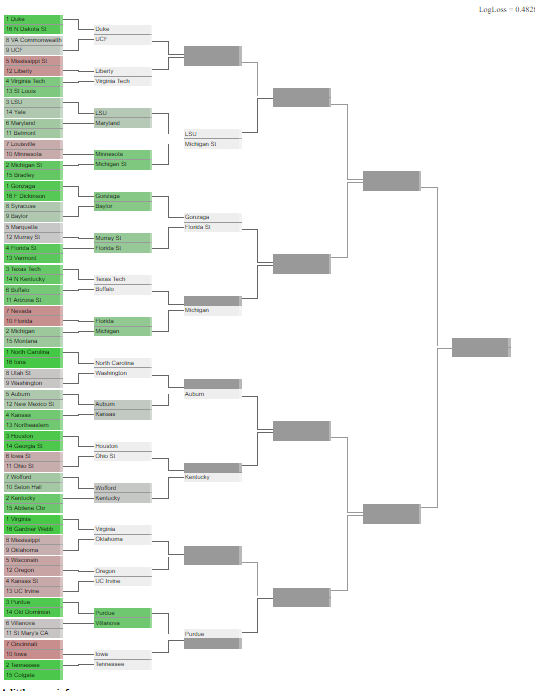

# The updated prediction, as of 24/03/2019, with the log loss of 0.482885681802539